In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
from torch_geometric.nn import GINEConv
from poker_embeddings.poker_utils.model import plot_train_loss, benchmark_dataloader
from poker_embeddings.poker_utils.constants import DECK_DICT
from poker_embeddings.poker_utils.datasets import UCIrvineDataset
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
X = pd.read_csv("../data/uc_irvine/X.csv")
y = pd.read_csv("../data/uc_irvine/y.csv")
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.6, random_state=29, stratify=y['CLASS']
    )
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

train_dataset = UCIrvineDataset(X_train, y_train, add_random_cards=True, use_card_ids=True,
                           graph=True, normalize_x=True)
val_dataset = UCIrvineDataset(X_val, y_val, add_random_cards=True, use_card_ids=True,
                           graph=True, normalize_x=True)

In [4]:
benchmark_dataloader(train_dataset, batch_sizes=[512, 1024], num_workers_list=[10], num_runs=5, graph=True)

Dataset size: 410004 samples
Batch size: 512, num_workers: 10, time: 18.087 seconds
Batch size: 1024, num_workers: 10, time: 17.406 seconds
Best params: batch_size=1024, num_workers=10, time 17.406


In [5]:
trainloader = tg.loader.DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    num_workers=10,
    pin_memory=True
    )
valloader = tg.loader.DataLoader(
    val_dataset,
    batch_size=512,
    shuffle=False,
    num_workers=10,
    pin_memory=True
    )

In [6]:

class CardGNN(nn.Module):
    def __init__(self, card_emb_dim=16, hidden_dim=16, out_dim=16, edge_attr_dim=2):
        super().__init__()
        self.card_embedder = nn.Embedding(53, card_emb_dim, padding_idx=52)

        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.card_emb_projector = nn.Linear(card_emb_dim, hidden_dim)
        self.gine1 = GINEConv(nn=self.node_mlp, edge_dim=edge_attr_dim)
        self.gine2 = GINEConv(nn=self.node_mlp, edge_dim=edge_attr_dim)
        self.final = nn.Linear(hidden_dim, out_dim)
        self.output_layer = nn.Linear(out_dim, 10)
    def forward(self, data):
        card_ids = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr

        x = self.card_embedder(card_ids)
        x = self.card_emb_projector(x)

        x = self.gine1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.gine2(x, edge_index, edge_attr)

        x = self.final(x)
        graphs_pooled = tg.utils.scatter(x, data.batch, dim=0, reduce='mean')
        return self.output_layer(graphs_pooled)


In [7]:
def train_model(model, trainloader, optimizer, scheduler=None, device=None,
                valloader=None, epochs=50, leftoff=0, save=True):

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    class_weights = torch.load("../model_weights/class_weights.pt", weights_only=True).to(device)
    for epoch in range(epochs):
        tot_train_loss = 0
        correct_train = 0
        total_train = 0

        model.train()
        for batch_data in trainloader:
            batch_data = batch_data.to(device)
            optimizer.zero_grad()

            logits = model(batch_data)

            batch_loss = F.cross_entropy(logits, batch_data.y, weight=class_weights)
            batch_loss.backward()
            optimizer.step()

            tot_train_loss += batch_loss.item()
            preds = logits.argmax(dim=1)
            correct_train += (preds == batch_data.y).sum().item()
            total_train += batch_data.y.size(0)

        avg_train_loss = tot_train_loss / len(trainloader)
        train_acc = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        if valloader is not None:
            model.eval()
            tot_val_loss = 0
            correct_val = 0
            total_val = 0

            with torch.no_grad():
                for batch_data in valloader:
                    batch_data = batch_data.to(device)
                    logits = model(batch_data)
                    batch_loss = F.cross_entropy(logits, batch_data.y, weight=class_weights)

                    tot_val_loss += batch_loss.item()
                    preds = logits.argmax(dim=1)
                    correct_val += (preds == batch_data.y).sum().item()
                    total_val += batch_data.y.size(0)

            avg_val_loss = tot_val_loss / len(valloader)
            val_acc = correct_val / total_val
            val_losses.append(avg_val_loss)
            val_accuracies.append(val_acc)

        if valloader is not None:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
        if save:
            if (epoch + 1) % 5 == 0:
                torch.save(model.state_dict(), f"../model_weights/hand_strength_predictor{leftoff+epoch+1}.pth")

        if scheduler is not None:
                scheduler.step()

    if valloader is not None:
        return {"train_loss":train_losses,
                "val_loss":val_losses,
                "train_accuracy":train_accuracies,
                "val_accuracy":val_accuracies}
    else:
        return {'train_loss':train_losses, "train_accuracy":train_accuracies}

In [8]:
model = CardGNN().to(device)

In [58]:
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [ ]:
res = train_model(
        model=model,
        trainloader=trainloader,
        valloader=None,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        epochs=100,
        leftoff=100,
        save=True
        )

Epoch 1/100, Train Loss: 0.0220, Train Acc: 0.9948
Epoch 2/100, Train Loss: 0.0178, Train Acc: 0.9952
Epoch 3/100, Train Loss: 0.0264, Train Acc: 0.9956
Epoch 4/100, Train Loss: 0.0228, Train Acc: 0.9951
Epoch 5/100, Train Loss: 0.0188, Train Acc: 0.9952
Epoch 6/100, Train Loss: 0.0195, Train Acc: 0.9954
Epoch 7/100, Train Loss: 0.0191, Train Acc: 0.9953
Epoch 8/100, Train Loss: 0.0165, Train Acc: 0.9960
Epoch 9/100, Train Loss: 0.0221, Train Acc: 0.9948
Epoch 10/100, Train Loss: 0.0165, Train Acc: 0.9962
Epoch 11/100, Train Loss: 0.0192, Train Acc: 0.9958
Epoch 12/100, Train Loss: 0.0147, Train Acc: 0.9962
Epoch 13/100, Train Loss: 0.0160, Train Acc: 0.9958
Epoch 14/100, Train Loss: 0.0210, Train Acc: 0.9958
Epoch 15/100, Train Loss: 0.0214, Train Acc: 0.9956
Epoch 16/100, Train Loss: 0.0172, Train Acc: 0.9958
Epoch 17/100, Train Loss: 0.0196, Train Acc: 0.9958
Epoch 18/100, Train Loss: 0.0254, Train Acc: 0.9954
Epoch 19/100, Train Loss: 0.0166, Train Acc: 0.9961
Epoch 20/100, Train L

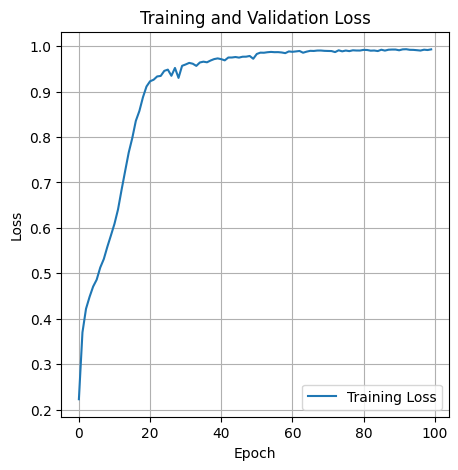

In [14]:
plot_train_loss(res['train_accuracy'])

In [15]:
def get_classification_report(model, dataloader, device=None):
    all_preds = []
    all_labels = []
    all_indices = []
    class_names = [
        "nothing", "one_pair", "two_pair", "three_of_a_kind", "straight",
        "flush", "full_house", "four_of_a_kind", "straight_flush", "royal_flush"
        ]
    model.eval()
    with torch.no_grad():
        for i, batch_data in enumerate(dataloader):
            batch_data = batch_data.to(device)

            logits = model(batch_data)
            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(batch_data.y.cpu())
            all_indices.extend(range(i * dataloader.batch_size, (i + 1) * dataloader.batch_size))
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    report = classification_report(all_labels, all_preds, target_names=class_names)
    cm = confusion_matrix(all_labels, all_preds)
    return {'report':report, 'confusion_matrix':cm,'labels':all_labels,'pred':all_preds}

In [19]:
pred_res = get_classification_report(model, valloader, device=device)
print(pred_res['report'])

                 precision    recall  f1-score   support

        nothing       1.00      1.00      1.00    308221
       one_pair       1.00      1.00      1.00    259858
       two_pair       1.00      1.00      1.00     29297
three_of_a_kind       1.00      1.00      1.00     12980
       straight       0.55      0.97      0.70      2387
          flush       0.98      0.99      0.99      1230
     full_house       1.00      1.00      1.00       876
 four_of_a_kind       1.00      1.00      1.00       142
 straight_flush       0.43      0.90      0.58        10
    royal_flush       0.00      0.00      0.00         5

       accuracy                           1.00    615006
      macro avg       0.80      0.89      0.83    615006
   weighted avg       1.00      1.00      1.00    615006



/home/campb/poker_embeddings/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/campb/poker_embeddings/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/campb/poker_embeddings/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [20]:
class_names = [
        "High Card", "Pair", "Two Pair", "Three of a Kind", "Straight",
        "Flush", "Full House", "Four of a Kind", "Straight Flush", "Royal Flush"
        ]

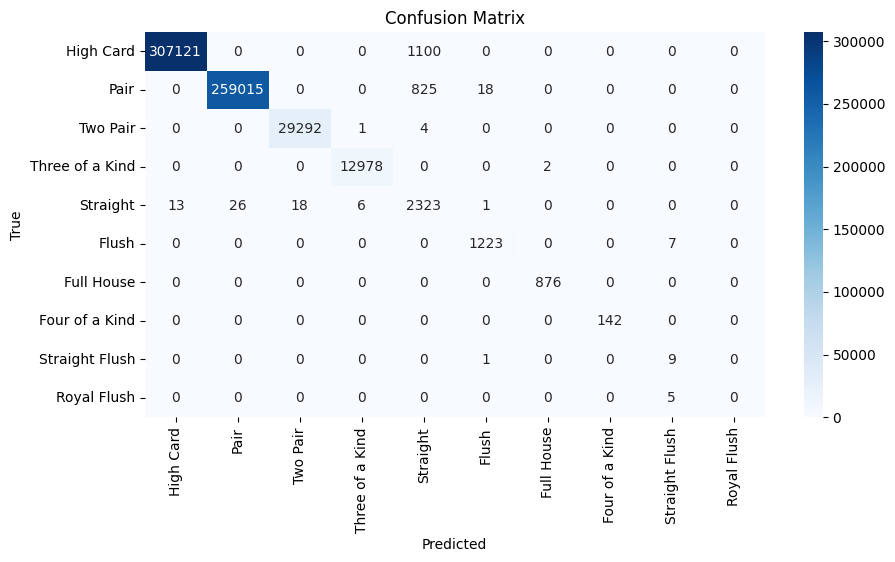

In [21]:
plt.figure(figsize=(10, 5))
sns.heatmap(pred_res['confusion_matrix'], annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [47]:
model.eval()
with torch.no_grad():
    card_embeddings = model.card_embedder.weight
    card_embeddings = model.card_emb_projector(card_embeddings).cpu()
    card_embeddings_norm = F.normalize(card_embeddings, p=2, dim=1).numpy()

In [29]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [50]:
tsne = TSNE(n_components=2, perplexity=30, max_iter=300)
emb_2d = tsne.fit_transform(card_embeddings_norm)

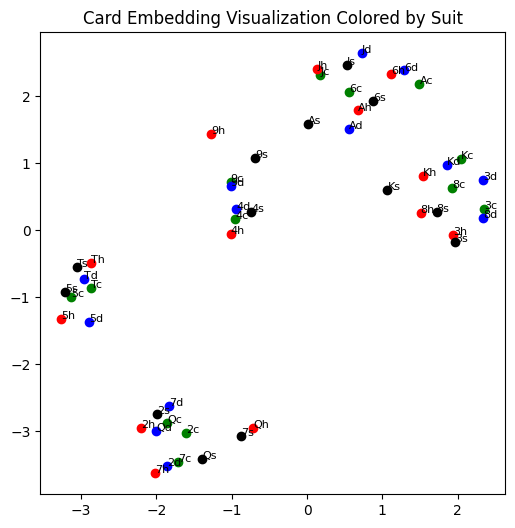

In [56]:
suit_colors = {
    0: 'green',    # Clubs
    1: 'blue',      # Diamonds
    2: 'red',     # Hearts
    3: 'black'     # Spades
}

colors = [suit_colors[i % 4] for i in range(len(DECK_DICT))]

# Now plot
plt.figure(figsize=(6, 6))
for i, txt in DECK_DICT.items():
    if i == 52:
        continue  # skip padding card if you have one
    plt.scatter(emb_2d[i, 0], emb_2d[i, 1], color=suit_colors[i % 4])
    plt.annotate(txt, (emb_2d[i, 0], emb_2d[i, 1]), fontsize=8)

plt.title("Card Embedding Visualization Colored by Suit")
plt.show()

/tmp/ipykernel_652403/3651916871.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rank_colors = plt.cm.get_cmap('tab20', 13)


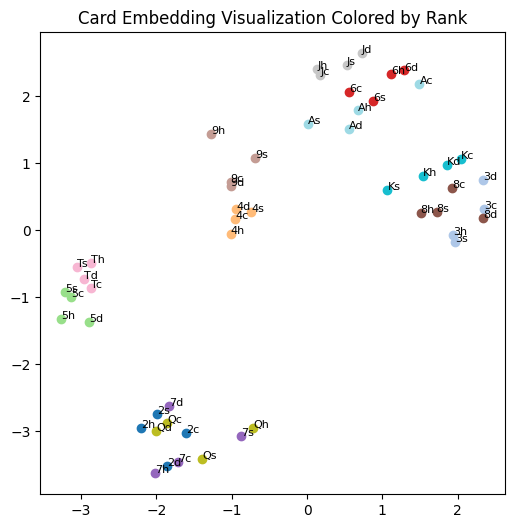

In [57]:
rank_colors = plt.cm.get_cmap('tab20', 13)

colors = [rank_colors(i // 4) for i in range(len(DECK_DICT))]

plt.figure(figsize=(6, 6))
for i, txt in DECK_DICT.items():
    if i == 52:
        continue
    plt.scatter(emb_2d[i, 0], emb_2d[i, 1], color=rank_colors(i // 4))
    plt.annotate(txt, (emb_2d[i, 0], emb_2d[i, 1]), fontsize=8)

plt.title("Card Embedding Visualization Colored by Rank")
plt.show()